# YouTube Trending Videos – Random Forest Classification

Goal: Predict whether a video gets **high views** (above median) or not  
Dataset: USvideos.csv from Kaggle YouTube Trending (2017–2018)

We will follow these steps cell by cell:

1. Import libraries  
2. Load & inspect data  
3. Create binary target (high_views)  
4. Prepare features & target  
5. Train/test split  
6. Train Random Forest  
7. Evaluate (accuracy, classification report, confusion matrix)  
8. Show feature importance

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Optional – better looking plots
sns.set_style("whitegrid")
%matplotlib inline

In [4]:
# Change this path to where your file actually is
# Example: "C:/Users/sai hein/Downloads/USvideos.csv"
#        or "./USvideos.csv" if it's in the same folder as notebook

df = pd.read_csv("USvideos.csv")

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

df.head(3)

Shape: (40949, 16)

Columns:
['video_id', 'trending_date', 'title', 'channel_title', 'category_id', 'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'description']


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
category_id,40949.0,1.997243e+01,7.568327e+00,1.0,17.0,24.0,25.0,43.0
views,40949.0,2.360785e+06,7.394114e+06,549.0,242329.0,681861.0,1823157.0,225211923.0
likes,40949.0,7.426670e+04,2.288853e+05,0.0,5424.0,18091.0,55417.0,5613827.0
dislikes,40949.0,3.711401e+03,2.902971e+04,0.0,202.0,631.0,1938.0,1674420.0
comment_count,40949.0,8.446804e+03,3.743049e+04,0.0,614.0,1856.0,5755.0,1361580.0


In [6]:
# Convert True/False columns to 0/1
df['comments_disabled'] = df['comments_disabled'].astype(int)
df['ratings_disabled']  = df['ratings_disabled'].astype(int)
df['video_error_or_removed'] = df['video_error_or_removed'].astype(int)

# Target: 1 = high views (above median), 0 = below median
median_views = df['views'].median()
df['high_views'] = (df['views'] > median_views).astype(int)

print("Median views:", median_views)
print("\nClass balance:")
print(df['high_views'].value_counts(normalize=True).round(3))

Median views: 681861.0

Class balance:
high_views
0    0.5
1    0.5
Name: proportion, dtype: float64


In [7]:
# Columns we will NOT use
drop_cols = [
    'video_id', 'trending_date', 'title', 'channel_title',
    'publish_time', 'tags', 'thumbnail_link', 'description',
    'views'               # ← target is derived from this → leakage
]

# Keep mostly numeric + the 3 boolean-like columns
feature_cols = [col for col in df.columns if col not in drop_cols + ['high_views']]

print("Features we will use:", feature_cols)

X = df[feature_cols]
y = df['high_views']

Features we will use: ['category_id', 'likes', 'dislikes', 'comment_count', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed']


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(f"Train: {X_train.shape[0]:,} rows")
print(f"Test : {X_test.shape[0]:,} rows")
print(f"Train high_views ratio: {y_train.mean():.3f}")

Train: 32,759 rows
Test : 8,190 rows
Train high_views ratio: 0.500


In [9]:
rf = RandomForestClassifier(
    n_estimators=120,
    max_depth=8,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

print("Training finished.")

Training finished.


In [10]:
y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}  ({acc*100:.2f}%)")

Test Accuracy: 0.8974  (89.74%)


In [11]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Low Views", "High Views"]))

Classification Report:

              precision    recall  f1-score   support

   Low Views       0.89      0.91      0.90      4095
  High Views       0.91      0.88      0.90      4095

    accuracy                           0.90      8190
   macro avg       0.90      0.90      0.90      8190
weighted avg       0.90      0.90      0.90      8190



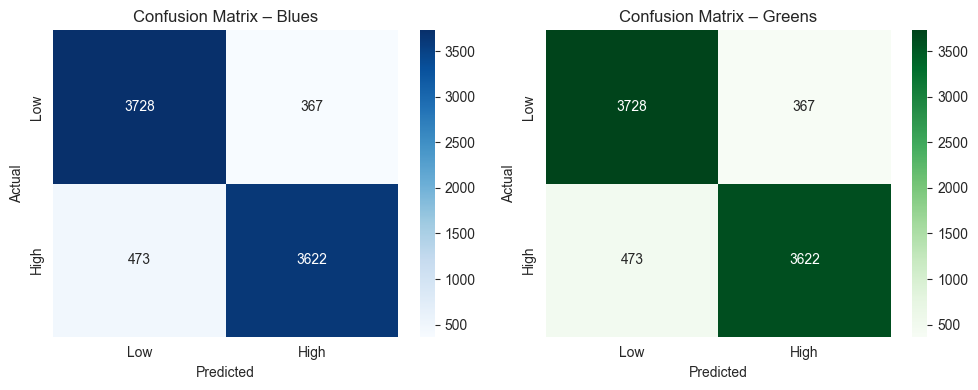

In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Blues")

plt.subplot(1,2,2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Greens")

plt.tight_layout()
plt.show()

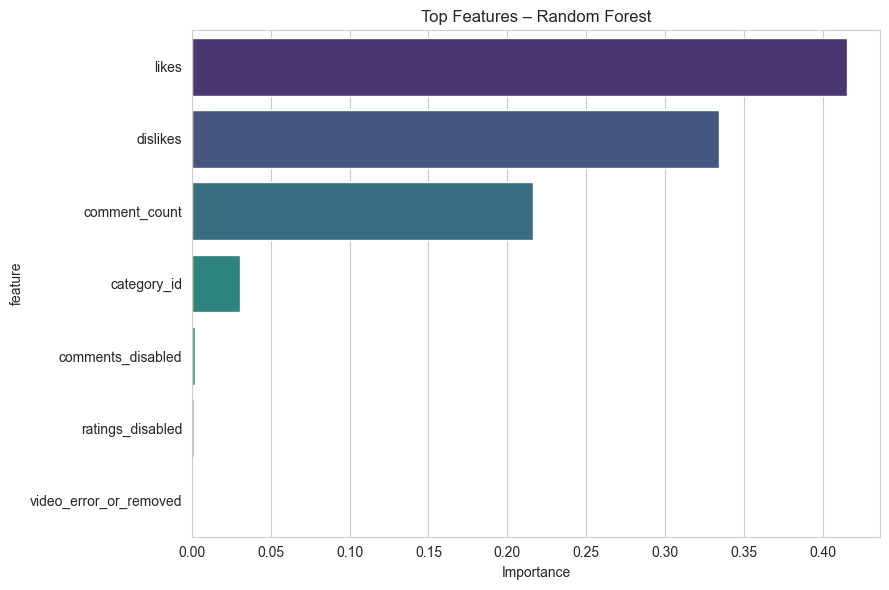

In [13]:
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(9, 6))
sns.barplot(x='importance', y='feature', data=importance.head(12), palette='viridis')
plt.title("Top Features – Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()